In [13]:
%pip install gurobipy
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
rnd = np.random
rnd.seed(51)

In [15]:
n = 6  # number of clients
f = 2  # number of charging stations
b = 2 #number of battery swapping stations
num_points = n + f + b
num_of_copies = 2
# Generate random coordinates for xc and yc
xc = np.random.rand(num_points) * 200
yc = np.random.rand(num_points) * 100

In [16]:
sum_xc=0
sum_yc=0
for i in xc:
    sum_xc+=i
for i in yc:
    sum_yc+=i
sum_xc/=num_points
sum_yc/=num_points

xc = np.insert(xc, 0, sum_xc)
yc = np.insert(yc, 0, sum_yc)

# Randomly select f points from the generated points
selected_indices = np.random.choice(np.setdiff1d(np.arange(1, num_points), 0), f+b, replace=False)
selected_xc = xc[selected_indices]
selected_yc = yc[selected_indices]

# Remove the selected points from xc and yc
xc = np.delete(xc, selected_indices)
yc = np.delete(yc, selected_indices)
xc=np.append(xc,xc[0])
yc=np.append(yc,yc[0])

selected_indices_f = np.random.choice(f+b, f, replace=False)
selected_xc_f = selected_xc[selected_indices_f]
selected_yc_f = selected_yc[selected_indices_f]

selected_xc = np.delete(selected_xc, selected_indices_f)
selected_yc = np.delete(selected_yc, selected_indices_f)
# print(xc)
# print(selected_xc_f)
# print(selected_xc)
b_x_coordinates=selected_xc;
b_y_coordinates=selected_yc;

# Append copies of each selected point after the first n points

for i in range(f):
    for _ in range(num_of_copies):
        xc = np.append(xc, selected_xc_f[i])
        yc = np.append(yc, selected_yc_f[i])

for i in range(b):
    for _ in range(num_of_copies):
        xc = np.append(xc, b_x_coordinates[i])
        yc = np.append(yc, b_y_coordinates[i])

print(xc)
print(yc)

[ 91.29500803   8.94243644  68.66073451 128.8039454  189.86756133
 117.99873529  97.55915826  91.29500803  56.84259975  56.84259975
  31.53403375  31.53403375  77.59459248  77.59459248 135.1462831
 135.1462831 ]
[28.68512033 21.81825612 64.67455442 24.98314091  4.7725783  44.54105029
  6.02748056 28.68512033 41.02479861 41.02479861 32.3548296  32.3548296
 29.22017587 29.22017587 17.4343386  17.4343386 ]


In [17]:
# xc = [65.53728031, 54.44603955, 88.12234968, 102.51692288, 31.34438071, 105.3051593, 65.53728031, 124.89947439, 124.89947439, 13.08142115, 13.08142115, 64.58673463, 64.58673463, 5.53304047, 5.53304047]
# yc = [49.32313992, 97.1122129, 54.21251519, 77.75853955, 6.09951352, 26.31270804, 49.32313992, 43.02173031, 43.02173031, 54.31221068, 54.31221068, 83.76162527, 83.76162527, 1.3172038, 1.3172038]

Text(89.29500803281795, 26.685120329608793, 'Depo')

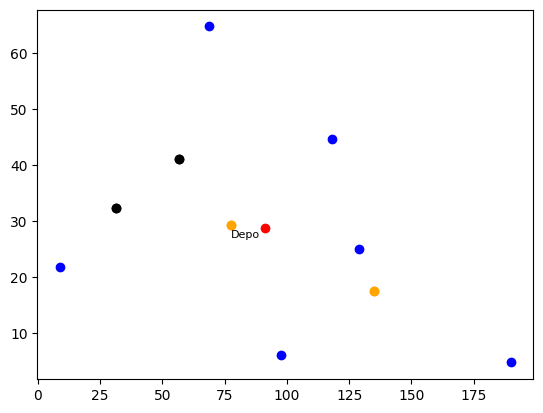

In [18]:
plt.scatter(xc[1:n+1], yc[1:n+1], c = 'blue')
plt.scatter(xc[n+2:n+2+f*num_of_copies],yc[n+2:n+2+f*num_of_copies], c= 'black')
plt.scatter(xc[n+2+f*num_of_copies:n+2+f*num_of_copies+b*num_of_copies],yc[n+2+f*num_of_copies:n+2+f*num_of_copies+b*num_of_copies], c= 'orange')
plt.scatter(xc[0], yc[0], c='r')
plt.text(xc[0]-2, yc[0]-2, 'Depo', fontsize=8, color='black', ha='right', va='bottom')

In [19]:
I = [i for i in range(1, n+1)] #Number of nodes/locations
F = [i for i in range(n+2,n+1+num_of_copies*f+1)]
B = [i for i in range(n+1+num_of_copies*f+1,n+1+num_of_copies*f+num_of_copies*b+1)]
F_comb = F + B
N = I + F + B
F_depo = [0] + F + B
I_depo = [0] + N
I_dest = N + [n+1]
I_depo_dest = N + [0] + [n+1]
num_of_vehicles = 5
K = [i for i in range(1,num_of_vehicles+1)]
A = [(i, j, k) for i in I_depo for j in I_dest for k in K if i != j] 
dist = [(i, j) for i in I_depo for j in I_dest if i != j] 
total_with_vehicles = [(i,k) for i in I_depo_dest for k in K]
kthVehicleChargingAndSwapping = [(i,k) for i in F_comb for k in K]
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in dist} 
lb = 14
ub = 20
C = {k: rnd.uniform(lb, ub) for k in K}
max_dist_limit = {k: rnd.uniform(lb*15,ub*20) for k in K}

S = 0.002  
thresholds = [50, 100, 150, 200]
multipliers = [1.0, 1.19, 1.29, 1.39, 1.49]
ranges=4
t_base = {}

for i, j, k in A:
    avg_value = c[i,j]
    if(c[i,j]<thresholds[0]):
        for k in K:
                t_base[i, j, k] = C[k] *S* multipliers[0]*c[i,j]
    elif(c[i,j]<=200):
         for x in range(0,ranges-1):
              if(c[i,j]>=thresholds[x] and c[i,j]<=thresholds[x+1]):
                           for k in K:
                               t_base[i, j, k] = C[k] *S* multipliers[x+1]*c[i,j]
    else:
         for k in K:
                t_base[i, j, k] = C[k] *S* multipliers[ranges-1]*c[i,j]

q = {i: rnd.uniform(1, 10) for i in N}
Q = [0]*(k+1)
fastTime = [0]*(n+1+num_of_copies*f+num_of_copies*b+1)
slowTime = [0]*(n+1+num_of_copies*f+num_of_copies*b+1)
mediumTime = [0]*(n+1+num_of_copies*f+num_of_copies*b+1)
batSwapTime = [0]*(n+1+num_of_copies*f+num_of_copies*b+1)
fastChargerCost = [0]*(n+1+num_of_copies*f+num_of_copies*b+1)
mediumChargerCost = [0]*(n+1+num_of_copies*f+num_of_copies*b+1)
slowChargerCost = [0]*(n+1+num_of_copies*f+num_of_copies*b+1)
batterySwapCost = [0]*(n+1+num_of_copies*f+num_of_copies*b+1)
fastStatNum = [0]*(n+1+num_of_copies*f+num_of_copies*b+1)
mediumStatNum = [0]*(n+1+num_of_copies*f+num_of_copies*b+1)
slowStatNum = [0]*(n+1+num_of_copies*f+num_of_copies*b+1)
batteryStatNum = [0]*(n+1+num_of_copies*f+num_of_copies*b+1)
cost = [0]*(k+1)
# Vehicle charging min and max constraints
minChargeValue = 4000
maxChargeValue = 6000

# Time constraints for fast 
minFastTimeValue = 2.0
maxFastTimeValue = 3.0

#Time constraint for medium
minMediumTimeValue = 4.0
maxMediumTimeValue = 5.0

#TIme constraint for slow
minSlowTimeValue = 7.0
maxSlowTImeValue = 8.0

#Time constraint for swapping battery
minBatSwapTime = 0.5
maxBatSwapTIme = 0.8

#Cost constraint for fast charging
minFastChargerCost = 300.0
maxFastChargerCost = 400.0

#Cost constraint for medium charging
minMediumChargerCost = 200.0
maxMediumChargerCost = 300.0

#Cost constraint for slow charging
minSlowChargerCost = 100.0
maxSlowChargerCost = 200.0

#Battery swap cost 
minBatterySwapCost = 550.0
maxBatterySwapCost = 650.0

#Max cost by vehicle
minVehicleCostValue = 8000
maxVehicleCostValue = 12000

for i in range(1,k+1):
      Q[i] = rnd.uniform(minChargeValue, maxChargeValue)
      cost[i] = rnd.randint(minVehicleCostValue, maxVehicleCostValue)

for i in range(n+2, n+1+num_of_copies*f+1):
      fastTime[i] = rnd.uniform(minFastTimeValue,maxFastTimeValue)
      mediumTime[i] = rnd.uniform(minMediumTimeValue, maxMediumTimeValue)
      slowTime[i] = rnd.uniform(minSlowTimeValue, maxSlowTImeValue)
      fastChargerCost[i] = rnd.uniform(minFastChargerCost, maxFastChargerCost)
      mediumChargerCost[i] = rnd.uniform(minMediumChargerCost, maxMediumChargerCost)
      slowChargerCost[i] = rnd.uniform(minSlowChargerCost, maxSlowChargerCost)
      fastStatNum[i] = 1
      slowStatNum[i] = 1
      mediumStatNum[i] = 1

for i in range(n+1+num_of_copies*f+1,n+1+num_of_copies*f+num_of_copies*b+1):
      batSwapTime[i] = rnd.uniform(minBatSwapTime, maxBatSwapTIme)
      batterySwapCost[i] = rnd.uniform(minBatterySwapCost,maxBatterySwapCost)
      batteryStatNum[i] = 1

q[0]=0
for i in range(n+1,n+2+num_of_copies*(f+b)):
    q[i] = 0

#For auxForTime
auxVariable = [(i,j,k) for i in I_depo for j in F_comb if i!=j for k in K]

# print(I)
# print(F)
# print(B)
# print(I_dest)
# print(I_depo)
# print(I)
# print(F)
# print(F_comb)
# print(B)
# print(auxVariable)
# print(t_base)

In [20]:
from gurobipy import Model, GRB, quicksum

H = 50 
Temp = 323
theta = 0.1
H = H*0.8 + Temp*(theta)

model = Model('ECVRP')
x = model.addVars(A, vtype=GRB.BINARY, name='x')
u = model.addVars(total_with_vehicles, vtype=GRB.CONTINUOUS,lb=0.0, name='u')
y = model.addVars(total_with_vehicles, vtype=GRB.CONTINUOUS,lb=0.0, name='y')
h = model.addVars(total_with_vehicles, vtype=GRB.CONTINUOUS, name='h')
fastCh = model.addVars(kthVehicleChargingAndSwapping, vtype = GRB.BINARY, name = "fast charging")
mediumCh = model.addVars(kthVehicleChargingAndSwapping, vtype = GRB.BINARY, name = "meidum charging")
slowCh = model.addVars(kthVehicleChargingAndSwapping, vtype = GRB.BINARY, name = "slow charging")
batterySwap = model.addVars(kthVehicleChargingAndSwapping, vtype = GRB.BINARY, name = "battery swapping")
auxForTime = model.addVars(auxVariable, vtype = GRB.CONTINUOUS, name = "auxForTime variable")
auxForCost = model.addVars(auxVariable, vtype = GRB.CONTINUOUS, name = "auxForCost variable")
for i,k in u.keys():
    u[i,k].ub = C[k]    
    u[i,k].lb = 0

for i,k in y.keys():
    y[i,k].ub = Q[k]
    y[i,k].lb = 0

model.modelSense = GRB.MINIMIZE
model.setObjective(quicksum(x[i, j, k]*t_base[i,j,k]*u[j,k] for i in I_depo for j in I_dest if i!=j for k in K) +  quicksum(auxForTime[i,j,k]*(Q[k] - y[j,k]) for i,j,k in auxVariable))
model.addConstrs((quicksum(x[i, j, k] for k in K for j in I_dest if i!=j) == 1 for i in I), name='outgoing')
model.addConstrs((quicksum(x[i, j, k] for k in K for j in I_dest if i!=j) <= 1 for i in F_comb), name='charging_outgoing')
model.addConstrs((quicksum(x[0, j, k] for j in N) <= 1 for k in K), name='charging_outgoing')
model.addConstrs((quicksum(x[i, j, k] for i in I_depo if i!=j)-quicksum(x[j,i,k] for i in I_dest if i!=j) == 0 for j in N for k in K), name='blockage')
model.addConstrs((u[j,k]<=u[i,k]-q[i]*x[i,j,k]+ C[k]*(1-x[i,j,k]) for i in I_depo for j in I_dest if i!=j for k in K), name='weight_transfer')
model.addConstrs(y[j,k]<=Q[k] - h[i,k]*c[i,j]*x[i,j,k] for i in F for j in I_dest if i!=j for k in K)
model.addConstrs((u[0,k]<=C[k] for k in K), name='Specifying_constant_weight')
model.addConstrs((y[0,k]==Q[k] for k in K), name='Specifying_constant_charge')
model.addConstrs((y[j,k]<=y[i,k]-h[i,k]*c[i,j]*x[i,j,k]+Q[k]*(1-x[i,j,k]) for i in I for j in I_dest  if i!=j for k in K), name = 'charge_left')
model.addConstrs(h[i,k] == H + u[i,k] / C[k] for i in I_depo_dest for k in K)
model.addConstrs(quicksum(fastCh[i,k] for k in K)<=fastStatNum[i] for i in F)
model.addConstrs(quicksum(mediumCh[i,k] for k in K)<=mediumStatNum[i] for i in F)
model.addConstrs(quicksum(slowCh[i,k] for k in K)<=slowStatNum[i] for i in F)
model.addConstrs(quicksum(batterySwap[i,k] for k in K)<=batteryStatNum[i] for i in B)
model.addConstrs(auxForTime[i,j,k]==x[i,j,k]*(fastCh[j,k]*fastTime[j] + slowCh[j,k]*slowTime[j] + mediumCh[j,k]*mediumTime[j]+ batterySwap[j,k]*batSwapTime[j]) for i,j,k in auxVariable)
model.addConstrs(auxForCost[i,j,k]==x[i,j,k]*(fastCh[j,k]*fastChargerCost[j] + slowCh[j,k]*slowChargerCost[j] + mediumCh[j,k]*mediumChargerCost[j]+ batterySwap[j,k]*batterySwapCost[j]) for i,j,k in auxVariable)
model.addConstrs((fastCh[i,k] + mediumCh[i,k] + slowCh[i,k])<=1 for i in F for k in K)
model.addConstrs(quicksum(auxForCost[i,j,k]*(Q[k]-y[j,k]) for i in I_depo for j in F_comb if i!=j)<=cost[k] for k in K)
model.Params.MIPGap = 0.1
model.Params.TimeLimit = 200 # seconds
model.params.NonConvex = 2

model.optimize()

Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 200
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6500U CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1270 rows, 2575 columns and 6485 nonzeros
Model fingerprint: 0x5ed11c97
Model has 1570 quadratic objective terms
Model has 1825 quadratic constraints
Variable types: 1360 continuous, 1215 integer (1215 binary)
Coefficient statistics:
  Matrix range     [5e-02, 3e+01]
  QMatrix range    [5e-01, 6e+02]
  QLMatrix range   [1e+00, 6e+03]
  Objective range  [4e+03, 6e+03]
  QObjective range [6e-01, 2e+01]
  Bounds range     [1e+00, 6e+03]
  RHS range        [1e+00, 6e+03]
  QRHS range       [4e+03, 1e+04]
Presolve added 1157 rows and 0 columns
Presolve removed 0 rows and 638 columns
Presolve time: 0.09s
Presolved: 6547 rows, 4124 columns, 24059 nonz

In [21]:
print(t_base)

{(0, 1, 1): 3.691905274782422, (0, 1, 2): 3.7795752741963775, (0, 1, 3): 3.1665274257864846, (0, 1, 4): 3.116855469470903, (0, 1, 5): 3.4659504862632464, (0, 2, 1): 1.5961252953169038, (0, 2, 2): 1.634027758487029, (0, 2, 3): 1.3689881365957823, (0, 2, 4): 1.3475134074133421, (0, 2, 5): 1.4984380236480248, (0, 3, 1): 1.4150167732514656, (0, 3, 2): 1.4486185345233615, (0, 3, 3): 1.213652325007912, (0, 3, 4): 1.1946142820150827, (0, 3, 5): 1.328413842798445, (0, 4, 1): 4.912296799389921, (0, 4, 2): 5.028946882604493, (0, 4, 3): 4.213250715049309, (0, 4, 4): 4.14715925986081, (0, 4, 5): 4.611650682591871, (0, 5, 1): 1.1659310659124622, (0, 5, 2): 1.1936179019110595, (0, 5, 3): 1.0000128448598566, (0, 5, 4): 0.9843260726751625, (0, 5, 5): 1.0945728679582327, (0, 6, 1): 0.8825321302639862, (0, 6, 2): 0.9034892203257294, (0, 6, 3): 0.7569430921499948, (0, 6, 4): 0.7450692508244876, (0, 6, 5): 0.8285187290488294, (0, 8, 1): 1.373885149915384, (0, 8, 2): 1.4065101771907713, (0, 8, 3): 1.178373

In [22]:
active_arcs = [a for a in A if x[a].x > 0.99]

values = {}
vehicle_dist={}
vehicle_time={}
for i,j,k in active_arcs:
    if(k not in vehicle_dist):
      vehicle_dist[k] = c[i,j]     
      vehicle_time[k] = (t_base[i,j,k])*(u[j,k].x)
    else:
         vehicle_dist[k]+=c[i,j]
         vehicle_time[k]+=(t_base[i,j,k])*(u[j,k].x)

    if i!=0:
        values[i]=(j,k)
        
colors = ['magenta', 'green', 'red', 'yellow', 'cyan']
def rec(i, j,k,col):
        print(i,j,k)
        mid_x = (xc[i] + xc[j]) / 2
        mid_y = (yc[i] + yc[j]) / 2
        plt.arrow(xc[i], yc[i], mid_x - xc[i], mid_y - yc[i],
                  head_width=2, head_length=2, fc='red', ec='red')   
        plt.plot([xc[i],xc[j]], [yc[i], yc[j]], c = colors[col])
        if(j==n+1):
             return
        rec(j,values[j][0],values[j][1],col)

print()


In [23]:
b = [active_aux for active_aux in auxVariable if auxForCost[active_aux].x>0.99]
c = [active_cost for active_cost in auxVariable if auxForCost[active_cost].x>0.99]
print(c)
print(b)

[]
[]


TypeError: unsupported operand type(s) for +: 'int' and 'list'

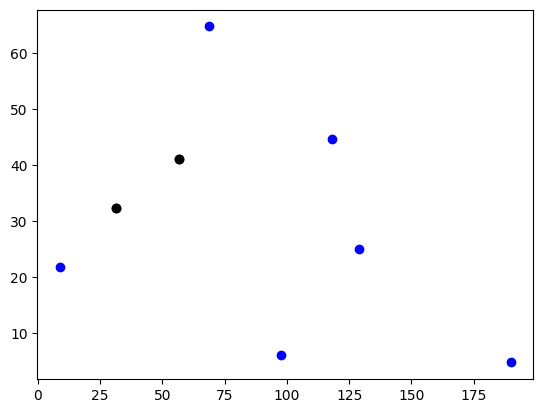

In [24]:
plt.scatter(xc[1:n+1], yc[1:n+1], c = 'blue')
plt.scatter(xc[n+2:n+2+f*num_of_copies],yc[n+2:n+2+f*num_of_copies], c= 'black')
plt.scatter(xc[n+2+f*num_of_copies:n+2+f*num_of_copies+b*num_of_copies],yc[n+2+f*num_of_copies:n+2+f*num_of_copies+b*num_of_copies], c= 'orange')
plt.scatter(xc[0], yc[0], c='r')
plt.text(xc[0]-2, yc[0]-2, 'Depo', fontsize=8, color='black', ha='right', va='bottom')

visited = []
for i in I:
    print(xc[i])
    if(xc[i] not in visited):
      plt.annotate('$q_%d = %d$' % (i,q[i]), (xc[i]-2, yc[i]+2))
      visited.append(xc[i])

count=1
for i in F:
    if(xc[i] not in visited):
      plt.annotate('BCS: $%d$' % count, (xc[i]-2, yc[i]+2))
      count+=1
      visited.append(xc[i])

count=1
for i in B:
    if(xc[i] not in visited):
      plt.annotate('BSS: $%d$' % count, (xc[i]-2, yc[i]+2))
      count+=1
      visited.append(xc[i])

col=0
for i,j,k in active_arcs:
    if(i==0):
        mid_x = (xc[i] + xc[j]) / 2
        mid_y = (yc[i] + yc[j]) / 2
        plt.arrow(xc[i], yc[i], mid_x - xc[i], mid_y - yc[i],
                  head_width=2, head_length=2, fc='red', ec='red')        
        rec(i,j,k,col)
        col+=1

total_charging_time=0
for i,j,k in active_arcs:
   if(j in F_comb):
      print(i,j,k, "aman")
      total_charging_time+=(auxForTime[i,j,k].x)*(Q[k]-y[j,k].x)
      print((auxForTime[i,j,k].x)*(Q[k]-y[j,k].x))
      print(y[j,k].x)

plt.title('With full charging: ')
plt.show()
